In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
sys.path.append("..")
import torch
import gcc
from gcc.datasets import (
    GRAPH_CLASSIFICATION_DSETS,
    GraphClassificationDataset,
    GraphClassificationDatasetLabeled,
    LoadBalanceGraphDataset,
    NodeClassificationDataset,
    NodeClassificationDatasetLabeled,
    worker_init_fn,
)
from gcc.datasets.data_util import batcher
from gcc.models import GraphEncoder
from gcc.datasets import data_util
from collections import defaultdict, namedtuple

from gcc.utils.splitter import scaffold_split, random_split
from gcc.datasets.data_util import batcher, labeled_batcher
from gcc.contrastive.memory_moco import MemoryMoCo
from torch import nn
from gcc.utils.misc import AverageMeter, adjust_learning_rate, warmup_linear

from sklearn.metrics import accuracy_score, f1_score

Using backend: pytorch
RDKit WARNING: [22:03:47] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
def train_finetune(
    epoch,
    train_loader,
    model,
    output_layer,
    criterion,
    optimizer,
    output_layer_optimizer,
    opt,
):
    """
    one epoch training for moco
    """
    n_batch = len(train_loader)
    model.train()
    output_layer.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    loss_meter = AverageMeter()
    f1_meter = AverageMeter()
    epoch_loss_meter = AverageMeter()
    epoch_f1_meter = AverageMeter()
    prob_meter = AverageMeter()
    graph_size = AverageMeter()
    max_num_nodes = 0
    max_num_edges = 0

    end = time.time()
    for idx, batch in enumerate(train_loader):
        data_time.update(time.time() - end)
        graph_q, y = batch

        graph_q
        y = y

        bsz = graph_q.batch_size

        # ===================forward=====================

        feat_q = model(graph_q)

        assert feat_q.shape == (graph_q.batch_size, opt.hidden_size)
        out = output_layer(feat_q)

        loss = criterion(out, y)

        # ===================backward=====================
        optimizer.zero_grad()
        output_layer_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 1)
        torch.nn.utils.clip_grad_value_(output_layer.parameters(), 1)
        global_step = epoch * n_batch + idx
        lr_this_step = opt.learning_rate * warmup_linear(
            global_step / (opt.epochs * n_batch), 0.1
        )
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr_this_step
        for param_group in output_layer_optimizer.param_groups:
            param_group["lr"] = lr_this_step
        optimizer.step()
        output_layer_optimizer.step()

        preds = out.argmax(dim=1)
        f1 = f1_score(y.cpu().numpy(), preds.cpu().numpy(), average="micro")

        # ===================meters=====================
        f1_meter.update(f1, bsz)
        epoch_f1_meter.update(f1, bsz)
        loss_meter.update(loss.item(), bsz)
        epoch_loss_meter.update(loss.item(), bsz)
        graph_size.update(graph_q.number_of_nodes() / bsz, bsz)
        max_num_nodes = max(max_num_nodes, graph_q.number_of_nodes())
        max_num_edges = max(max_num_edges, graph_q.number_of_edges())

        #torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % opt.print_freq == 0:
            mem = psutil.virtual_memory()
            print(
                "Train: [{0}][{1}/{2}]\t"
                "BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                "DT {data_time.val:.3f} ({data_time.avg:.3f})\t"
                "loss {loss.val:.3f} ({loss.avg:.3f})\t"
                "f1 {f1.val:.3f} ({f1.avg:.3f})\t"
                "GS {graph_size.val:.3f} ({graph_size.avg:.3f})\t"
                "mem {mem:.3f}".format(
                    epoch,
                    idx + 1,
                    n_batch,
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=loss_meter,
                    f1=f1_meter,
                    graph_size=graph_size,
                    mem=mem.used / 1024 ** 3,
                )
            )
    return epoch_loss_meter.avg, epoch_f1_meter.avg

def test_finetune(epoch, valid_loader, model, output_layer, criterion, opt):
    n_batch = len(valid_loader)
    model.eval()
    output_layer.eval()

    epoch_loss_meter = AverageMeter()
    epoch_f1_meter = AverageMeter()

    for idx, batch in enumerate(valid_loader):
        graph_q, y = batch

        bsz = graph_q.batch_size

        # ===================forward=====================

        with torch.no_grad():
            feat_q = model(graph_q)
            assert feat_q.shape == (graph_q.batch_size, opt.hidden_size)
            out = output_layer(feat_q)
        loss = criterion(out, y)

        preds = out.argmax(dim=1)
        f1 = f1_score(y.cpu().numpy(), preds.cpu().numpy(), average="micro")

        # ===================meters=====================
        epoch_loss_meter.update(loss.item(), bsz)
        epoch_f1_meter.update(f1, bsz)

    global_step = (epoch + 1) * n_batch
    #sw.add_scalar("ft_loss/valid", epoch_loss_meter.avg, global_step)
    #sw.add_scalar("ft_f1/valid", epoch_f1_meter.avg, global_step)
    #print(
    #    f"Epoch {epoch}, loss {epoch_loss_meter.avg:.3f}, f1 {epoch_f1_meter.avg:.3f}"
    #)
    return epoch_loss_meter.avg, epoch_f1_meter.avg

def print_model_args(args):
    for arg in vars(args):
        print(arg , " ", vars(args)[arg])
        
def test_moco(train_loader, model, opt):
    """
    one epoch training for moco
    """

    model.eval()

    emb_list = []
    for idx, batch in enumerate(train_loader):
        graph_q, graph_k = batch
        bsz = graph_q.batch_size
        graph_q.to(opt.device)
        graph_k.to(opt.device)

        with torch.no_grad():
            feat_q = model(graph_q)
            feat_k = model(graph_k)

        assert feat_q.shape == (bsz, opt.hidden_size)
        emb_list.append(((feat_q + feat_k) / 2).detach().cpu())
    return torch.cat(emb_list)

save_results_to = '/media/nedooshki/f4f0aea6-900a-437f-82e1-238569330477/GRL-course-project/results'
def create_dataframe_save_to_csv(embeddings, labels, dataset_name, model_name, save_path):
    filename = '{}_{}.csv'.format(dataset_name, model_name)
    emb_df = pd.DataFrame(np.array(embeddings))
    emb_df.columns = ['emb' + str(e+1) for e in range(emb_df.shape[1])]
    emb_df['label'] = labels
    emb_df.to_csv(os.path.join(save_path, filename), sep='\t', index=False)

## Loading pre-trained model

In [3]:
checkpoint = torch.load('../saved/Pretrain_moco_False_dgl_gin_layer_5_lr_0.005_decay_1e-05_bsz_256_hid_64_samples_2000_nce_t_0.07_nce_k_32_rw_hops_256_restart_prob_0.8_aug_1st_ft_False_deg_16_pos_32_momentum_0.999/current.pth', map_location="cpu")
#print_model_args(checkpoint["opt"])
args = checkpoint["opt"]
args.device = torch.device("cpu")
model = GraphEncoder(
        positional_embedding_size=args.positional_embedding_size,
        max_node_freq=args.max_node_freq,
        max_edge_freq=args.max_edge_freq,
        max_degree=args.max_degree,
        freq_embedding_size=args.freq_embedding_size,
        degree_embedding_size=args.degree_embedding_size,
        output_dim=args.hidden_size,
        node_hidden_dim=args.hidden_size,
        edge_hidden_dim=args.hidden_size,
        num_layers=args.num_layer,
        num_step_set2set=args.set2set_iter,
        num_layer_set2set=args.set2set_lstm_layer,
        gnn_model=args.model,
        norm=args.norm,
        degree_input=True,
    )
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

## Embeddings from pre-trained model

In [35]:
imdb_binary_train_dataset = GraphClassificationDataset(
            dataset='imdb-binary',
            rw_hops=args.rw_hops,
            subgraph_size=args.subgraph_size,
            restart_prob=args.restart_prob,
            positional_embedding_size=args.positional_embedding_size,
        )
args.batch_size = len(imdb_binary_train_dataset)
imdb_binary_train_loader = torch.utils.data.DataLoader(
    dataset=imdb_binary_train_dataset,
    batch_size=args.batch_size,
    collate_fn=batcher(),
    shuffle=False,
    num_workers=args.num_workers,
)
imdb_binary_emb = test_moco(imdb_binary_train_loader, model, args)
imdb_binary_labels = data_util.create_graph_classification_dataset("imdb-binary").graph_labels
create_dataframe_save_to_csv(imdb_binary_emb,imdb_binary_labels,'imdbb','GCC',save_results_to)

In [34]:
imdb_multi_train_dataset = GraphClassificationDataset(
            dataset='imdb-multi',
            rw_hops=args.rw_hops,
            subgraph_size=args.subgraph_size,
            restart_prob=args.restart_prob,
            positional_embedding_size=args.positional_embedding_size,
        )
args.batch_size = len(imdb_multi_train_dataset)
imdb_multi_train_loader = torch.utils.data.DataLoader(
    dataset=imdb_multi_train_dataset,
    batch_size=args.batch_size,
    collate_fn=batcher(),
    shuffle=False,
    num_workers=args.num_workers,
)
imdb_multi_emb = test_moco(imdb_multi_train_loader, model, args)
imdb_multi_labels = data_util.create_graph_classification_dataset("imdb-multi").graph_labels
create_dataframe_save_to_csv(imdb_multi_emb,imdb_multi_labels,'imdbm','GCC',save_results_to)

Extracting file to /home/nedooshki/.dgl/tu_IMDB-MULTI


In [24]:
bbbp_train_dataset = GraphClassificationDataset(
            dataset='bbbp',
            rw_hops=args.rw_hops,
            subgraph_size=args.subgraph_size,
            restart_prob=args.restart_prob,
            positional_embedding_size=args.positional_embedding_size,
        )
smile_path = '/media/nedooshki/f4f0aea6-900a-437f-82e1-238569330477/GRL-course-project/pretrain-gnns-master/chem/dataset/bbbp/processed/smiles.csv'
smiles_list = pd.read_csv(smile_path, header=None)[0].tolist()
train_dataset, valid_dataset, test_dataset = scaffold_split(bbbp_train_dataset, smiles_list, null_value=0, frac_train=0.8,frac_valid=0.1, frac_test=0.1)
args.batch_size = len(bbbp_train_dataset)
bbbp_train_loader = torch.utils.data.DataLoader(
    dataset=bbbp_train_dataset,
    batch_size=args.batch_size,
    collate_fn=batcher(),
    shuffle=False,
    num_workers=args.num_workers,
)
bbbp_test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=args.batch_size,
    collate_fn=batcher(),
    shuffle=False,
    num_workers=args.num_workers,
)
#bbbp_emb = test_moco(bbbp_train_loader, model, args)
bbbp_labels = data_util.create_graph_classification_dataset("bbbp").graph_labels
#create_dataframe_save_to_csv(bbbp_emb,bbbp_labels,'bbbp','GCC',save_results_to)
test_labels = [bbbp_labels[i] for i in test_dataset.indices]
test_bbbp_emb = test_moco(bbbp_test_loader, model, args)
create_dataframe_save_to_csv(test_bbbp_emb,test_labels,'test_bbbp','GCC',save_results_to)

RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [22:15:13] WARNING: not r

In [25]:
bace_train_dataset = GraphClassificationDataset(
            dataset='bace',
            rw_hops=args.rw_hops,
            subgraph_size=args.subgraph_size,
            restart_prob=args.restart_prob,
            positional_embedding_size=args.positional_embedding_size,
        )
args.batch_size = len(bace_train_dataset)
smile_path = '/media/nedooshki/f4f0aea6-900a-437f-82e1-238569330477/GRL-course-project/pretrain-gnns-master/chem/dataset/bace/processed/smiles.csv'
smiles_list = pd.read_csv(smile_path, header=None)[0].tolist()
train_dataset, valid_dataset, test_dataset = scaffold_split(bace_train_dataset, smiles_list, null_value=0, frac_train=0.8,frac_valid=0.1, frac_test=0.1)
bace_train_loader = torch.utils.data.DataLoader(
    dataset=bace_train_dataset,
    batch_size=args.batch_size,
    collate_fn=batcher(),
    shuffle=False,
    num_workers=args.num_workers,
)
bace_test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=args.batch_size,
    collate_fn=batcher(),
    shuffle=False,
    num_workers=args.num_workers,
)
#bace_emb = test_moco(bace_train_loader, model, args)
bace_labels = data_util.create_graph_classification_dataset("bace").graph_labels
#create_dataframe_save_to_csv(bace_emb,bace_labels,'bace','GCC',save_results_to)

test_labels = [bace_labels[i] for i in test_dataset.indices]
test_bace_emb = test_moco(bace_test_loader, model, args)
create_dataframe_save_to_csv(test_bace_emb,test_labels,'test_bace','GCC',save_results_to)

## Loading checkpoint

In [26]:
checkpoint = torch.load('../saved/Pretrain_moco_False_dgl_gin_layer_5_lr_0.005_decay_1e-05_bsz_256_hid_64_samples_2000_nce_t_0.07_nce_k_32_rw_hops_256_restart_prob_0.8_aug_1st_ft_False_deg_16_pos_32_momentum_0.999/current.pth', map_location="cpu")
#print_model_args(checkpoint["opt"])
args = checkpoint["opt"]
args.device = torch.device("cpu")

## Loading IMDB dataset

In [8]:
dataset_name = 'imdb-binary'
dataset = GraphClassificationDatasetLabeled(
                dataset=dataset_name,
                rw_hops=args.rw_hops,
                subgraph_size=args.subgraph_size,
                restart_prob=args.restart_prob,
                positional_embedding_size=args.positional_embedding_size,
            )
labels = dataset.dataset.graph_labels
train_dataset, valid_dataset, test_dataset = random_split(dataset, frac_train=0.8,frac_valid=0.1, frac_test=0.1, seed = args.seed)
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        collate_fn=labeled_batcher(),
        shuffle=True,
        num_workers=args.num_workers,
        worker_init_fn=None,
    )
valid_loader = torch.utils.data.DataLoader(
            dataset=valid_dataset,
            batch_size=args.batch_size,
            collate_fn=labeled_batcher(),
            num_workers=args.num_workers,
    )
test_loader = torch.utils.data.DataLoader(
            dataset=test_dataset,
            batch_size=args.batch_size,
            collate_fn=labeled_batcher(),
            num_workers=args.num_workers,
    )

## Loading Molecule dataset

In [106]:
dataset_name = 'bace'
dataset = GraphClassificationDatasetLabeled(
                dataset=dataset_name,
                rw_hops=args.rw_hops,
                subgraph_size=args.subgraph_size,
                restart_prob=args.restart_prob,
                positional_embedding_size=args.positional_embedding_size,
            )
labels = dataset.dataset.graph_labels
smile_path = '/media/nedooshki/f4f0aea6-900a-437f-82e1-238569330477/GRL-course-project/pretrain-gnns-master/chem/dataset/' + dataset_name + '/processed/smiles.csv'
smiles_list = pd.read_csv(smile_path, header=None)[0].tolist()
train_dataset, valid_dataset, test_dataset = scaffold_split(dataset, smiles_list, null_value=0, frac_train=0.8,frac_valid=0.1, frac_test=0.1)
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        collate_fn=labeled_batcher(),
        shuffle=True,
        num_workers=args.num_workers,
        worker_init_fn=None,
    )
valid_loader = torch.utils.data.DataLoader(
            dataset=valid_dataset,
            batch_size=args.batch_size,
            collate_fn=labeled_batcher(),
            num_workers=args.num_workers,
    )
test_loader = torch.utils.data.DataLoader(
            dataset=test_dataset,
            batch_size=args.batch_size,
            collate_fn=labeled_batcher(),
            num_workers=args.num_workers,
    )

## Supervised from scratch

In [12]:
model, model_ema = [
        GraphEncoder(
            positional_embedding_size=args.positional_embedding_size,
            max_node_freq=args.max_node_freq,
            max_edge_freq=args.max_edge_freq,
            max_degree=args.max_degree,
            freq_embedding_size=args.freq_embedding_size,
            degree_embedding_size=args.degree_embedding_size,
            output_dim=args.hidden_size,
            node_hidden_dim=args.hidden_size,
            edge_hidden_dim=args.hidden_size,
            num_layers=args.num_layer,
            num_step_set2set=args.set2set_iter,
            num_layer_set2set=args.set2set_lstm_layer,
            norm=args.norm,
            gnn_model=args.model,
            degree_input=True,
        )
        for _ in range(2)
    ]
output_layer = nn.Linear(
            in_features=args.hidden_size, out_features=dataset.dataset.num_labels
        )
contrast = MemoryMoCo(
        args.hidden_size, None, args.nce_k, args.nce_t, use_softmax=True
    )
criterion = nn.CrossEntropyLoss()
output_layer_optimizer = torch.optim.Adam(
            output_layer.parameters(),
            lr=args.learning_rate,
            betas=(args.beta1, args.beta2),
            weight_decay=args.weight_decay,
        )

def clear_bn(m):
    classname = m.__class__.__name__
    if classname.find("BatchNorm") != -1:
        m.reset_running_stats()

model.apply(clear_bn)
optimizer = torch.optim.Adam(
            model.parameters(),
            lr=args.learning_rate,
            betas=(args.beta1, args.beta2),
            weight_decay=args.weight_decay,
        )

using queue shape: (32,64)


In [13]:
train_losses = []
train_f1s = []
valid_losses = []
valid_f1s = []
test_losses = []
test_f1s = []
for epoch in range(1, 51):

        adjust_learning_rate(epoch, args, optimizer)
        time1 = time.time()
        train_loss, train_f1 = train_finetune(
            epoch,
            train_loader,
            model,
            output_layer,
            criterion,
            optimizer,
            output_layer_optimizer,
            args,
        )
        valid_loss, valid_f1 = test_finetune(
            epoch, 
            valid_loader, 
            model, 
            output_layer, 
            criterion, 
            args
        )
        test_loss, test_f1 = test_finetune(
            epoch, 
            test_loader, 
            model, 
            output_layer, 
            criterion, 
            args
        )
        time2 = time.time()
        train_losses.append(train_loss)
        train_f1s.append(train_f1)
        valid_losses.append(valid_loss)
        valid_f1s.append(valid_f1)
        test_losses.append(test_loss)
        test_f1s.append(test_f1)

## Fine-tuning from pre-trained model

In [16]:
model, model_ema = [
        GraphEncoder(
            positional_embedding_size=args.positional_embedding_size,
            max_node_freq=args.max_node_freq,
            max_edge_freq=args.max_edge_freq,
            max_degree=args.max_degree,
            freq_embedding_size=args.freq_embedding_size,
            degree_embedding_size=args.degree_embedding_size,
            output_dim=args.hidden_size,
            node_hidden_dim=args.hidden_size,
            edge_hidden_dim=args.hidden_size,
            num_layers=args.num_layer,
            num_step_set2set=args.set2set_iter,
            num_layer_set2set=args.set2set_lstm_layer,
            norm=args.norm,
            gnn_model=args.model,
            degree_input=True,
        )
        for _ in range(2)
    ]
output_layer = nn.Linear(
            in_features=args.hidden_size, out_features=dataset.dataset.num_labels
        )
contrast = MemoryMoCo(
        args.hidden_size, None, args.nce_k, args.nce_t, use_softmax=True
    )
criterion = nn.CrossEntropyLoss()
output_layer_optimizer = torch.optim.Adam(
            output_layer.parameters(),
            lr=args.learning_rate,
            betas=(args.beta1, args.beta2),
            weight_decay=args.weight_decay,
        )

def clear_bn(m):
    classname = m.__class__.__name__
    if classname.find("BatchNorm") != -1:
        m.reset_running_stats()

model.apply(clear_bn)
optimizer = torch.optim.Adam(
            model.parameters(),
            lr=args.learning_rate,
            betas=(args.beta1, args.beta2),
            weight_decay=args.weight_decay,
        )
model.load_state_dict(checkpoint["model"])
contrast.load_state_dict(checkpoint["contrast"])

using queue shape: (32,64)


<All keys matched successfully>

In [17]:
ft_train_losses = []
ft_train_f1s = []
ft_valid_losses = []
ft_valid_f1s = []
ft_test_losses = []
ft_test_f1s = []
for epoch in range(1,51):

        adjust_learning_rate(epoch, args, optimizer)

        time1 = time.time()
        train_loss, train_f1 = train_finetune(
            epoch,
            train_loader,
            model,
            output_layer,
            criterion,
            optimizer,
            output_layer_optimizer,
            args,
        )
        valid_loss, valid_f1 = test_finetune(
            epoch, 
            valid_loader, 
            model, 
            output_layer, 
            criterion, 
            args
        )
        test_loss, test_f1 = test_finetune(
            epoch, 
            test_loader, 
            model, 
            output_layer, 
            criterion, 
            args
        )
        
        time2 = time.time()
        ft_train_losses.append(train_loss)
        ft_train_f1s.append(train_f1)
        ft_valid_losses.append(valid_loss)
        ft_valid_f1s.append(valid_f1)
        ft_test_losses.append(test_loss)
        ft_test_f1s.append(test_f1)

In [18]:
losses = pd.DataFrame(columns = ['split', 'training_type', 'epoch', 'loss'])
losses = pd.concat([losses, pd.DataFrame({'split': 'train', 'training_type': 'No pre-training', 'epoch': np.arange(1,51), 'loss': train_losses})])
losses = pd.concat([losses, pd.DataFrame({'split': 'valid', 'training_type': 'No pre-training', 'epoch': np.arange(1,51), 'loss': valid_losses})])
losses = pd.concat([losses, pd.DataFrame({'split': 'train', 'training_type': 'Fine-tuning', 'epoch': np.arange(1,51), 'loss': ft_train_losses})])
losses = pd.concat([losses, pd.DataFrame({'split': 'valid', 'training_type': 'Fine-tuning', 'epoch': np.arange(1,51), 'loss': ft_valid_losses})])
f1s = pd.DataFrame(columns = ['split', 'training_type', 'epoch', 'f1'])
f1s = pd.concat([f1s, pd.DataFrame({'split': 'train', 'training_type': 'No pre-training', 'epoch': np.arange(1,51), 'f1': train_f1s})])
f1s = pd.concat([f1s, pd.DataFrame({'split': 'valid', 'training_type': 'No pre-training', 'epoch': np.arange(1,51), 'f1': valid_f1s})])
f1s = pd.concat([f1s, pd.DataFrame({'split': 'train', 'training_type': 'Fine-tuning', 'epoch': np.arange(1,51), 'f1': ft_train_f1s})])
f1s = pd.concat([f1s, pd.DataFrame({'split': 'valid', 'training_type': 'Fine-tuning', 'epoch': np.arange(1,51), 'f1': ft_valid_f1s})])


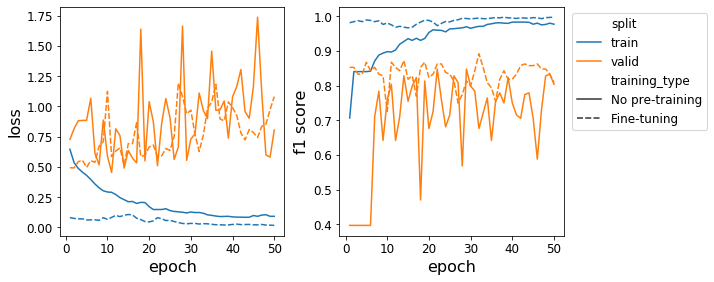

In [85]:
params = {'legend.fontsize': 12,
         'axes.labelsize': 16,
         'axes.titlesize':20,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12}
plt.rcParams.update(params)
fig, axs = plt.subplots(1,2, figsize = (10,4))
sns.lineplot(data = losses, x = 'epoch', y = 'loss', hue = 'split', style = 'training_type', ax = axs[0])
axs[0].set(xlabel='epoch',ylabel='loss')
axs[0].legend_.remove()
sns.lineplot(data = f1s, x = 'epoch', y = 'f1', hue = 'split', style = 'training_type', ax = axs[1])
axs[1].set(xlabel='epoch',ylabel='f1 score')
axs[1].legend(bbox_to_anchor=(1.01, 1), ncol=1)
fig.tight_layout(pad=1.0)
#fig.savefig('/media/nedooshki/f4f0aea6-900a-437f-82e1-238569330477/GRL-course-project/results/plots/bbbp_GCC_losses.png', dpi=300)

In [28]:
ft_imdbb = [0.65,0.64,0.65,0.66,0.64,0.64,0.64,0.62]
sw_imdbb = [0.66,0.72,0.73,0.69,0.7,0.71,0.71,0.71]
ft_imdbm = [0.48,0.47,0.49,0.46,0.47,0.48,0.47,0.47]
sw_imdbm = [0.49,0.51,0.47,0.48,0.49,0.46,0.48,0.5]
print('ft_imdbb is {}\u00B1{}'.format(round(np.mean(ft_imdbb),2), round(np.sqrt(np.var(ft_imdbb)),2)))
print('sw_imdbb is {}\u00B1{}'.format(round(np.mean(sw_imdbb),2), round(np.sqrt(np.var(sw_imdbb)),2)))
print('ft_imdbm is {}\u00B1{}'.format(round(np.mean(ft_imdbm),2), round(np.sqrt(np.var(ft_imdbm)),2)))
print('sw_imdbm is {}\u00B1{}'.format(round(np.mean(sw_imdbm),2), round(np.sqrt(np.var(sw_imdbm)),2)))
ft_bace = [0.66,0.64,0.63,0.62,0.63,0.64,0.63,0.66,0.68,0.61]
sw_bace = [0.65,0.62,0.63,0.64,0.57,0.62,0.65,0.62,0.65,0.62]
ft_bbbp = [0.55,0.56,0.55,0.56,0.57,0.58,0.57,0.57,0.57,0.57]
sw_bbbp = [0.57,0.55,0.54,0.52,0.53,0.54,0.55,0.54,0.54,0.57]
print('ft_bace is {}\u00B1{}'.format(round(np.mean(ft_bace),2), round(np.sqrt(np.var(ft_bace)),2)))
print('sw_bace is {}\u00B1{}'.format(round(np.mean(sw_bace),2), round(np.sqrt(np.var(sw_bace)),2)))
print('ft_bbbp is {}\u00B1{}'.format(round(np.mean(ft_bbbp),2), round(np.sqrt(np.var(ft_bbbp)),2)))
print('sw_bbbp is {}\u00B1{}'.format(round(np.mean(sw_bbbp),2), round(np.sqrt(np.var(sw_bbbp)),2)))

ft_imdbb is 0.64±0.01
sw_imdbb is 0.7±0.02
ft_imdbm is 0.47±0.01
sw_imdbm is 0.48±0.02
ft_bace is 0.64±0.02
sw_bace is 0.63±0.02
ft_bbbp is 0.57±0.01
sw_bbbp is 0.55±0.01
